# Introduction

In this Notebook I will walk you through how supervised classification works. You will learn everything you need, to build your own binary or multiclass classification systems. I got everything I cover in this notebook from the book "Hands-On Machine Learning with Scikit_learn & Tensorflow" from Aurelien Geron. I used the famous mnist dataset, which contains 70,000 images of handwritten digits. 

If you just want to have a quick look at what I did and what I've learned throughout writing this notebook, you can just read the [summary](#Summary) at the very end.  



## Table of Contents:
- [Import Libraries](#import)

- [Data Exploration and Preparation](#explo)

- [Train SGD Classifier](#sgd)

- [Evaluate Performance](#evaluate)

- [Confusion Matrix](#confusion)

- [Precision & Recall](#precisionr)

- [Precision/Recall Tradeoff](#precision)

- [ROC Curve and ROC AUC Score](#roc)

- [Multiclass Classification](#multiclass)

- [Error Analysis](#Error2)

- [Multilabel Classification](#Multilabel)

- [Summary](#Summary)


<a id='import'></a>

# Import Libraries

In [1]:
# Common imports
import numpy as np
import os

# random seed to make output stable across runs
np.random.seed(42)

# data visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

<a id='explo'></a>

#  Data Exploration and Preparation

In [2]:
# fetch dtatset from sklearn
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X_label, y_label = mnist["data"], mnist["target"]
X_label.shape

(70000, 784)

The whole dataset contains 70,000 images and every Image has 784 features, because every image is 28x28 pixels big. Each image represents the intensity of one pixel from 0 (white) to 255 (black). 

The dataset is splitted into a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image. 

Let's look at one image:

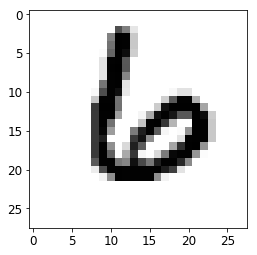

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

digit = X_label[66045]
digit_image = digit.reshape(28, 28)
plt.imshow(digit_image, cmap = matplotlib.cm.binary)
  

#plt.axis("off")
plt.show()

In [12]:
y_label[66043] # print the label of the image above

6.0

In [13]:
# separating feature and labels for both train and test set
X_train, X_test, y_train, y_test = X_label[:60000], X_label[60000:], y_label[:60000], y_label[60000:]

In [14]:
# shuffle the training, so that there aren't many similar digist in a row 
shuffle_the_indexes = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_the_indexes], y_train[shuffle_the_indexes]

<a id='sgd'></a>

# Train SGD Classifier

To understand the overall concept of classification better, we will start by developing and training a classiffier that classifies one digit - for example, the number 6. This classifier will be capable of distinguishing between two classes, 6 and not 6. Afterwords we will build one that classifies every digit out of the dataset.

In [15]:
# creating target vectors
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)

As classifier we use sklearns stochastic gradient descent (SGD), which is capable of handling large dataset efficiently. It deals with one instance at a time. 

In [16]:
# creat SGDClassifier & train it on the training set
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=None)
sgd_clf.fit(X_train, y_train_6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [17]:
# detect images of the number 6, using the "digit" variable we used above, that contains a 6.
prediction = sgd_clf.predict([digit])
print("Prediction:", prediction[0])

Prediction: True


The classifier correctly classified the number 6.

<a id='evaluate'></a>

# Evaluate Performance

Since evaluating a classifier is often harder that evaluating a regressor, we will spend a lot of time at this part of the project. Now we will use cross-validation to evaluate our current binary classifier (SGD). 

K-fold cross validation splits the training set into K-folds. Afterwards it makes predictions and evuluates them on each fold using a model trained on the remaining fold. 

Sometimes, you want more controll over the cross validation process, than with the pre-implemented one, that sklearn provides. Therefore I will implement cross-validation by myself, just to gain some more experience.

I will use StratifiedKFold, which performs stratified sampling to produce several folds that contain a representative ratio of each class. The cross validator creates a clone of the classifier and then trains that clone on the training folds and makes predictions on the test fold afterwards. In the end, it counts the correct predictions and gives us the performance ratio.

We will evaluate our SGDClassifier model using K-fold cross validation, with three folds.

In [18]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_6):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_6[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_6[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print("Accuracy:",n_correct / len(y_pred))

Accuracy: 0.9823008849557522
Accuracy: 0.98155
Accuracy: 0.9813490674533727


We got above 97 % accuracy on every fold but before we get too amazed, we will create a very stupid classifier, that just classifies every image as not a 6. 

In [19]:
from sklearn.base import BaseEstimator
class not_a_6(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_6_clf = not_a_6()
from sklearn.model_selection import cross_val_score # out of simplicits, we just use the build in cross validator
accuracy = cross_val_score(never_6_clf, X_train, y_train_6, cv=3, scoring="accuracy")
print("Accuracy:", accuracy)

Accuracy: [0.8993  0.90115 0.90365]


Also over 90% accuracy on every fold. This is because just around 10% of the images are sixes and if you therefore always guess an image is not a 6, you will be right 90% of the time.

This is the reason why accuracy is the wrong measure for classiffiacation problems in machine learning. This is especially true, when some classes are much more frequent than others (e.g skewed dataset).

A much better measure of how good our model does, is the so called confusion matrix, which we will cover below.

<a id='confusion'></a>

# Confusion Matrix

A confusion matrix simply counts how often instances of class A are classified as class B. If you would want to know how often the classifier confused for example a 6 with a 4, you would look at the 6th row and the 4th column of the confusion matrix. 

To use the confusion matrix, we will first need predictions that can be compared to the actual target. We will use the cross_vall_predict() function, which returns the clean predictions made on each test set, instead of the evaluated scores that the cross_val_score() function returns. Clean means the prediction is made by a model, that never saw the data before. 

In [21]:
# cross_val_predict()
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3)

In [22]:
# building confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6, predictions)

array([[53459,   623],
       [  473,  5445]], dtype=int64)

Each row represents an actual class and each column represents a predicted class.

The first row is about non 6 images (the negative class), where 53459 images were correctly classified as non-6s (called true negatives). The remaining 623 images were wrongly classified as 6s (false positives).

The second row represents the actual 6 images. 473 were wrongly classified as non-6s (false negatives). 5445 were correctly classified as 6 (true positives). 

Note that the perfect classifier would be right 100% of the time, which means he would have only true positives and true negatives. 

A confusion matrix gives you a lot of information about how well your model does, but theres a way to get even more,  like the computing the classifiers precision. This is basically the accuracy of the positive predictions and it is often viewed along with the so called "recall". We will discuss how they work in the next section. 

<a id='precisionr'></a>

# Precision & Recall

Like I already mentioned, the precision is the accuracy of the positive predictions. It is typically viewed together with "recall", which is the ratio of correctly detected positive instances.

Sklearn provides build in function to compute them.

In [23]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_6, predictions)

0.8973302570863546

In [24]:
recall_score(y_train_6, predictions)

0.9200743494423792

Now we have a much better evaluation of our classifier. Our model classifies 89% of the time images correctly as a 6. The precision tells us that it predicted 92 % of the 6s as a 6. 

But there is still a better way ! You can combine precision and recall into one single metric, called the F-score. 
The F-score is really useful if you want to compare 2 classifiers. It is computed using the harmonic mean of precision and recall, and gives much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_6, predictions)

0.908559986651093

There we have it, a 90 % F-score.

But unfortunately the F-score isn't the holy grail and has it's tradeoffs. It favors classifiers that have similar precision and recall. This is a probpem, because you sometimes want a high precision and sometimes a high recall. The thing is that an increasing precision, results in an decreasing recall and vice versa. This is called the precision/recall tradeoff and we will cover it in the next section. 

<a id='precision'></a>

# Precision/Recall Tradeoff

To illustrate this tradeoff a little bit better, I will give you examples for when you want a high precision and when you want a high recall.

1. high precision:

You probably want a high precision, if you trained a classifier to detect videos that are suited for children. This means you want a classifier that may rejects a lot of videos that would be actually suited for kids, but never shows you a video that contains adult content. therefore only shows safe ones (e.g a high precision)

2. high recall:

A example where you would need a high recall, is if you train a classifier that detects people, who are trying to break into a building. It would be fine if the classifier has only 25 % precision (would result in some false alarms), as long as it has a 99% recall and alarms you nearly every time when someone trys to break in. 

To understand this tradeoff even better, we will look at how the SGDClassifier makes it's classification decisions. For each image it has to classify, it computes a score based on a decision function and it classifies the image as one number (when the score is bigger the than threshold) or another (when the score is smaller than the threshold).


The picture below shows digits, that are ordered from the lowest (left) to the highest score (right). Let's suppose you have a classifier that should detect 5s and the threshold is positioned at the middle of the picture (at the central arrow). Then you would spot 4 true positives (actual 5s) and one false positive (actually a 6) on the right of it. The positioning of that threshold would result in a 80% precision (4 out of 5), but out of the six actual 5s on the picture, he would only identify 4, so the recall would be 67% (4 out of 6). If you would now move the threshold to the right arrow, it would result in a higher precision but in a lower recall and vice versa if you move the threshold to the left arrow. 

![img](https://img1.picload.org/image/ddwodplr/bildschirmfoto2018-02-03um17.2.png)

Unfortunately, sklearn doesn't let you choose the threshold, but there is a way around this issue, because you can see the decision scores that sklearn used for it's predictions. So instead of the "predict()" function, you can call the "decision_function()", which returns a score for each instance. Afterwards you can make predictions based on that score, using any threshold you want. 

In [26]:
# we use the "digit" variabel again, which contains a 6
y_scores = sgd_clf.decision_function([digit])
y_scores

array([382003.91805683])

In [27]:
threshold = 0
y_digit_pred = (y_scores > threshold)

y_digit_pred

array([ True])

The usual SGD Classifier uses a treshold equal to 0, so the previous code gives us roughly the same result, as if we had used the normal "predict()" method. But now comes the interesting part, because we ill raise the threshold.

In [21]:
threshold = 500000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

This little experiment confirms that raising the threshold is decreasing the recall. The image is actually representing a 6 and it is classified correctly with a threshold of 0, but it is classified wrong if the threshold is raised. 

How we can decide which threshold is the best ?

To solve this problem, we need to first get the scores of all the instances in the training set, using "cross_val_predict()" function. But this time we want it to return decisions scores and not predictions:

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3, method="decision_function")

Now we are able to compute the recall and the precision using the "precision_recall_curve()" function:

In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_6, y_scores)

To get a better understanding of the recall and precision we computed above, we will plot them both as functions of the threshold using matplotlib:

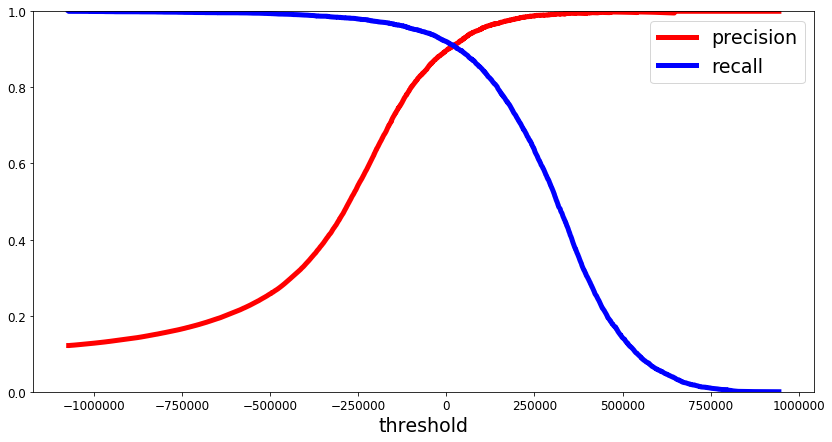

In [30]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Another way is to plot the precision and recall against each other:

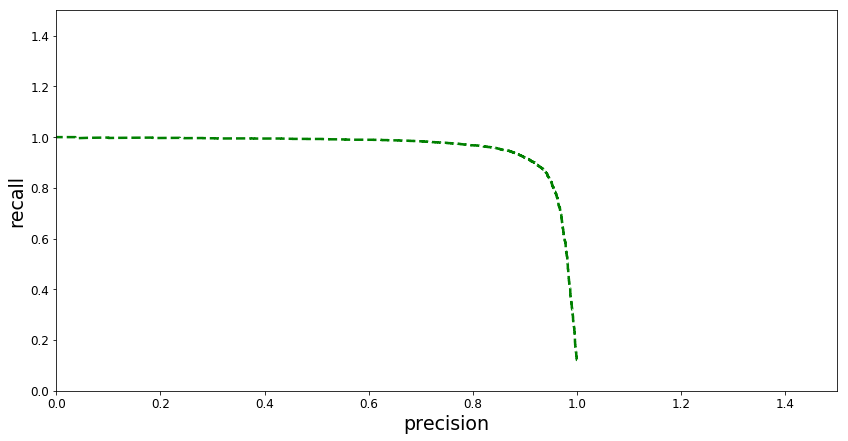

In [31]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

Above you can clearly see that the recall is falling of sharply at a precision of around 95%. Therefore you probably want to choose to select the precision/recall tradeoff before that - maybe at around 85 %.

Because of the two plots above, you are now able to choose a threshold, that gives you the best precision/recall tradeoff for your current machine learning problem. 

If you want for example a precision of 85%, you can easily look at the plots and see that you would need a threshold of around - 50,000. To then make a prediction, you don't have to call the "predict()" method, because you can just run the code below:

In [32]:
y_train_pred_99 = (y_scores > - 50000)

In [33]:
# let's check if it worked
precision_score(y_train_6, y_train_pred_99)

0.8554993097100783

Great ! Now we know how we can create a classifier with virtually any precision we want. We also learned that this is not as desirible as it sounds, because a high precision is not very usefull in combination with a low recall ratio. So the next time you hear someone talking about a precision of 99%, you know that you should asked him about the recall.

<a id='roc'></a>

# ROC Curve and ROC AUC Score

The ROC curve is another tool to to evaluate and compare binary classifiers. It has a lot of similarities with the precision/recall curve, although it is quite different. It plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances), instead of plotting the precision versus the recall. 

To generate a ROC curve, we need to compute the true positive rate and the false positive rate for several threshold values. We can use the "roc_curve()" function for this task. Afterwards we need to plot them against each other with matplotlib.

In [43]:
# compute true positive rate and false positive rate
from sklearn.metrics import roc_curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_6, y_scores)


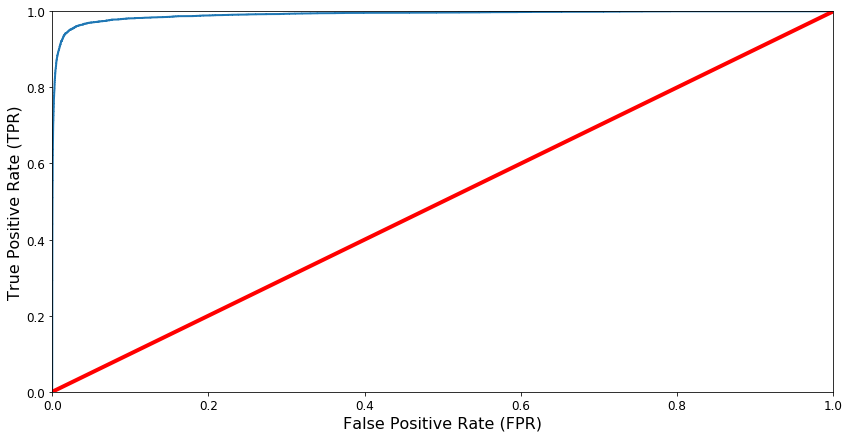

In [44]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Of course we also have a tradeoff here, because the classifier produces more false positives, the higher the true positive rate is. The red line in the middel is a purely random classifier and therefore your classifier should be as far away from it as possible. 

The ROC curve provides also a way to compare two classifiers with each other, by measuring the area under the curve (called AUC). Note that a classifiers that is 100% correct, would have a ROC AUC of 1. A completely random classiffier would have a score of 0.5. 

In [36]:
# computing ROC AUC
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_train_6, y_scores)
print("ROC-AUC-Score:", score)

ROC-AUC-Score: 0.9914368951887224


Let's train a another classifier, so that we can compared it with our previous SGDCLassifier,  using the ROC curve and ROC AUC score. We will use a RandomForestClassifier, which is also build into  sklearn. 

To train a RandomForestClassifier we first need to get scores for each instance in the training set. Unfortunately this function has no "decision_function()" , instead it has the "predict_proba()" function. The "predict_proba()" function returns an array that contains a row per instance and a column per class, each contains the probability that the given instance belongs to the given class (e.g a 86% probability that the image represents a 6).

In [37]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(random_forest, X_train, y_train_6, cv=3, method = "predict_proba")

The problem is that we need scores not probabilities to plot the AUC ROC curve. To solve this issue, we use the positive class's  probability as the score:

In [38]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_6, y_scores_forest)

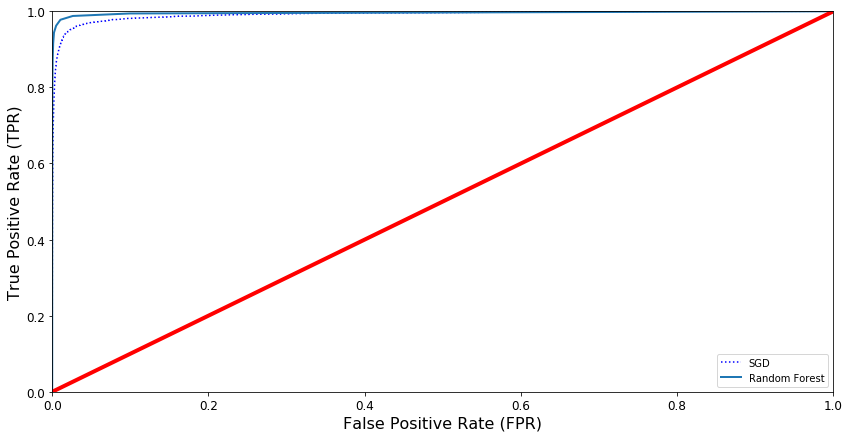

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(false_positive_rate, true_positive_rate, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")

plt.show()

In [40]:
# ROC AUC Score:
score = roc_auc_score(y_train_6, y_scores_forest)
print("ROC-AUC-Score:", score)

ROC-AUC-Score: 0.9959054781807241


In [41]:
# Precision:
y_train_pred_forest = cross_val_predict(random_forest, X_train, y_train_6, cv=3)
score = precision_score(y_train_6, y_train_pred_forest)
print("Precision:", score)

Precision: 0.9877848678213309


In [42]:
# recall:
score = recall_score(y_train_6, y_train_pred_forest)
print("Recall:", score) 

Recall: 0.9155119972963839


The RandomForestsClassifiers ROC curve looks better than the one of the SGDClassifier, because it comes closer to the top left corner.


Now we definitely learned a lot of stuff. We learned how to train a binary classififer, how to to evaluate it and with which tool, how to use cross validation, how to select the right precision/recall tradeoff and how to compare different classifiers with the ROC AUC score. Now it is time to tackle multiclass classification.

<a id='multiclass'> </a>

# Multiclass Classification

Now we will work on building a solid classifier that can distinguish between more than just two classes (e.g Multiclass Classification). 

Out there are algorithms that can deal by themselves with predicting multiple classes, like Random Forest classifiers or naive bayes classiffiers. There are also algorithms that can't do that, like Support Vector Machine classiffiers and Linear classiffiers, but with some tricks, you can predict multiple classes with them too.

Let's discuss the most common of these "tricks":

1) one-versus-all (OvA) Strategy:

With this strategy, you train 10 binary classifiers, one for each number. This simply means training one classifier to detect 0s, one to detect 1s, one to detect 2s and so on. When you then want to classify an image, you just look at which classifier has the best decision score

2) one-versus-one (OvO) Strategy:

Here you train a binary classifier for every pair of digits. This means training a classifier that can distinguish between 0s and 1s, one that can distiguish between 0s and 2s, one that can distinguish between 1s and 2s etc. If there are N classes, you would need to train NxN(N-1)/2 classifiers, which are 45 in the case of the mnist dataset. When you then want to classify images, you need to run every of these 45 classiffiers and choose the best performing one. This strategy has one big advantage over the others and this is, that you only need to train it on a part of the training set for the 2 classes it distinguishes between. 
Algorithms like Support Vector Machine Classifiers don't scale good at large datasets, which is why in this case the OvO strategy would do better, because it is faster to train a lot of classifiers on a small  dataset, than training just one at a large dataset.  


At most algorithms, sklearn automatically recognizes, when you use a binary classifier for a multiclass classification tasks and uses the OvA strategy. There is an exception: When you try to use a Support Vector Machine classifier, it automatically runs the OvO strategy. 

We will now try to train a SGDClassifier for multiclass classification:

In [37]:
# training the classifier on all target classes from 0 to 9
sgd_clf.fit(X_train, y_train) 

# now we ask it to predict the "digit" variable, which contains a 6
sgd_clf.predict([digit]) 

array([ 6.])

There we have it. Our classifiers successfully classified our image as a 6.
Behind the scenes, sklearn trained 10 separate binary classifiers and selected the one with the highest decision score.

To proof that this is really happening, we can call the "decision_function()". It should return 10 scores now, not just one like it previously did.

In [38]:
digit_scores = sgd_clf.decision_function([digit])
digit_scores

array([[-913982.70456115, -647401.4825082 , -671785.4952167 ,
        -951875.84162795, -232825.71980206, -479321.63360506,
         336792.13994462, -834085.76134867, -557907.55380941,
        -251559.37311632]])

In [39]:
np.argmax(digit_scores)

6

In [40]:
# When a classifier is trained, he stores a list of target classes in the classes_attribute
# usually ordered by vlaue
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [41]:
# the index of each class should match the class itself
sgd_clf.classes_[6]

6.0

There is also a way to force sklearn to use OvO for example at an SGDClassifier:

In [42]:
from sklearn.multiclass import OneVsOneClassifier
# just create an instance and pass the SGDClassifier in it
force_ovo = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=5, tol=None))
force_ovo.fit(X_train, y_train)
force_ovo.predict([digit])

array([ 6.])

It classified the actual 6 correctly.

I previsouly mentioned that a RandomForestClassifier is capable of classifying multiple classes by itself. 
Therefore we will train one below:

In [43]:
# let's change the number we want to predict to a 5
digit = X_label[36000]
# train random forest
random_forest.fit(X_train, y_train)
random_forest.predict([digit])

array([ 5.])

In [44]:
# call "predict_proba()" to get the probabilities assigned to each instance
random_forest.predict_proba([digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

You can see from the output of the "predict_proba()" function, that the classifier assigned a 80 % probably to the image being a 5. We can also see, that it assigned a 10% chance to the image being a 0 or 3.

Now we will evaluate our newly trained SGD classifier. We will do this by using the cross validation and the "cross_val_score()" function:

In [45]:
accuracy = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# calculate mean of the 3 accuracies
mean_of_accuracy = np.mean(accuracy)
print("Accuracy:", mean_of_accuracy)

Accuracy: 0.852051434248


It get's on average a 85% accuracy, which is not a bad score but theres still room for improvement. One way to improve our score is to scale the inputs:

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
accuracy = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# calculate mean of the 3 accuracies
mean_of_accuracy = np.mean(accuracy)
print("Accuracy:", mean_of_accuracy)

Accuracy: 0.908499803025


Now it get's a 91 % accuracy on average. Not bad ! 
Let's check the precision, recall and F-score:

In [47]:
# getting a precision:

# 1. get clean predictions
predictions = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

# 2. compute prtecision
# since we are now dealing with multilabel classiffication, 
# wee need to specify a value for the average parameter, here: 'macro'.
# 'macro' calculates metrics for each label & finds their unweighted mean. 
precision = precision_score(y_train, predictions, average='macro')
print("Precision:", precision)

Precision: 0.907446027435


In [48]:
# recall
recall = recall_score(y_train, predictions, average='macro')
print("Recall:", recall)

Recall: 0.907446027435


In [49]:
# F-score
f1_score = f1_score(y_train, predictions, average='macro')
print("F-Score:", f1_score)

F-Score: 0.907238052565


<a id='Error2'> </a>

# Error Analysis
Since this is no real machine learning project and the feature-engineering etc. was all done for us before, there are only a few things left, to improve our model. One way to improve our model would be to look at what errors it makes and trying to analyze them.

First we will look at the confusion matrix:

In [50]:
#y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
#confusion_matrix = confusion_matrix(y_train, y_train_pred)
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
confusion_matrix = confusion_matrix(y_train, y_train_pred)
#conf_mx

In [51]:
confusion_matrix

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

This bunch of numbers can't really help us. We should use matplotlib to plot the confusion matrix for us:

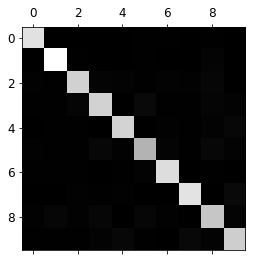

In [52]:
plt.matshow(confusion_matrix, cmap = plt.cm.gray)
plt.show()

This confusion matrix looks good but if you analyze it more detailed, you can see that the 5s look a bit darker then the other images. This could mean that our model just predicts the 5s not as good as the other digits, or that there just are fewe 5s in the dataset. 

Let's create a plot that shows us the errors better than this one. First, we will divide each value within the confusion matrix by the sum of images in the corresponding class, so that we are able to compare error rates instead of absolute number errors. We don't want to compare absolute number erros, because these would make abundant classes look more bad than their actually are.

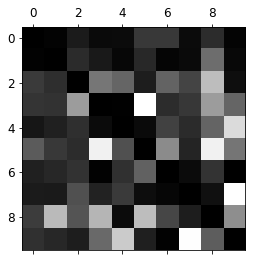

In [53]:
sum_of_rows = confusion_matrix.sum(axis=1, keepdims=True)
norm_confusion_matrix = confusion_matrix / sum_of_rows

# let's now fill the diagonal with zeros to keep nothing but the errors:
np.fill_diagonal(norm_confusion_matrix, 0)
plt.matshow(norm_confusion_matrix, cmap=plt.cm.gray)
plt.show()                          

If we look closely at the plot above, we can spot a few patterns. Remember that columns represent predicted classes and rows actual classes. 

The first thing that we can notice is that some rows and columns are more brighter and some are more darker than others. A bright one (at this plot), means that many images get misclassified and dark ones tell us that the many images get classified correctly.

Now we can argue that the 8 and 9 columns are bright and therefore these numbers get often classififed wrong.
The same is the case for the 8 and 9 rows. Also the row 1 looks pretty dark and therefore get's often classiffied correct.

We now know that we can improve our model even further by solving these issues. We could improve the classiffication of 8s and 9s and fix the 3/5 confusion. 

For example, we could gather more training data for specific numbers by copying and then rotating some of the images. Another solution would be writing an algortihm that counts the number of closed loops in a number (6 has one, 8 has two and so on). Or we could preprocess the images with tools like opencv or so to make some patterns, that makes a digit unique, more outstanding. Another things would be to preprocess images so that they are better centered and not too rotated.


<a id='Multilabel'></a>

<a id='Capstone'> </a>

# Summary

Now we have a pretty good understanding of how supervised classification works. 

We learned about several algorithms, like SGD Classifiers, RandomForest Classiffiers, Naive Bayes Classifiers, SVM Classiffiers and Linear Classiffiers. We learned about their advantages and disadvantages and how to implement them. We learned which ones are suited for binary classification and which ones are suited for multiclass classiffication. 

We also gained knowledge about strategies like one-versus-all (OvA) and one-versus-one (OvO), that help use to use a binary classifier at a multiclass classiffication problem. 

Furthermore we implemented and learned about K-fold cross validation and how to correctly evaluate classififers. 

In terms of evaluation we learned why accuracy is generally not the preferred performance measure for classifiers, how a confusion matrix works, what precision & recall are, what an F-score is and what disadvantages it has (like favoring classifiers with similar and high precision and recall). 

We also discovered the recall/precision tradeoff, the ROC curve, the ROC AUC score and also it's tradeoff.

I think we now learned enough to tackle classification problems and how to compare the output of different models with each other.